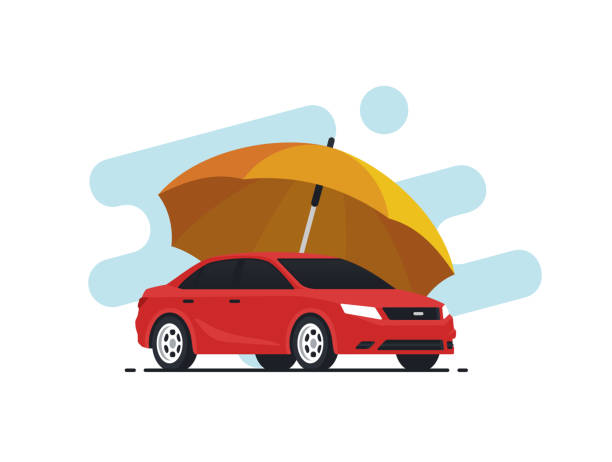
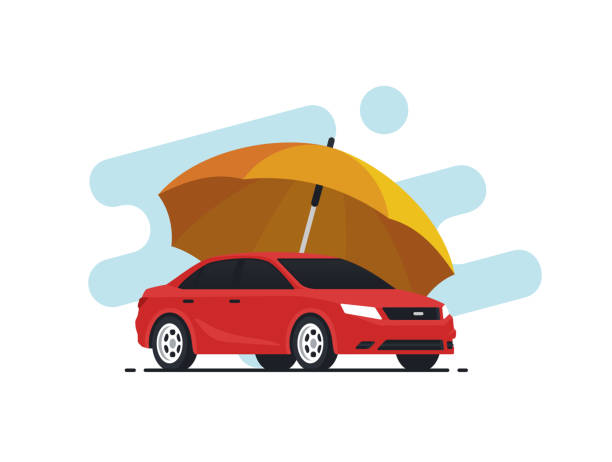

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/vehicle-insurance-fraud-detection/carclaims.csv


In [2]:
df = pd.read_csv("/kaggle/input/vehicle-insurance-fraud-detection/carclaims.csv")

In [3]:
df.tail()

Month  WeekOfMonth  DayOfWeek     Make AccidentArea DayOfWeekClaimed  \
15415   Nov            4     Friday   Toyota        Urban          Tuesday   
15416   Nov            5   Thursday  Pontiac        Urban           Friday   
15417   Nov            5   Thursday   Toyota        Rural           Friday   
15418   Dec            1     Monday   Toyota        Urban         Thursday   
15419   Dec            2  Wednesday   Toyota        Urban         Thursday   

      MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  \
15415          Nov                   5    Male       Married  ...   
15416          Dec                   1    Male       Married  ...   
15417          Dec                   1    Male        Single  ...   
15418          Dec                   2  Female       Married  ...   
15419          Dec                   3    Male        Single  ...   

       AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
15415           31 to 35                No             No  External   
15416           31 to 35                No             No  External   
15417           26 to 30                No             No  External   
15418           31 to 35                No             No  External   
15419           26 to 30                No             No  External   

      NumberOfSuppliments  AddressChange-Claim  NumberOfCars  Year  \
15415                none            no change     1 vehicle  1996   
15416         more than 5            no change        3 to 4  1996   
15417              1 to 2            no change     1 vehicle  1996   
15418         more than 5            no change     1 vehicle  1996   
15419              1 to 2            no change     1 vehicle  1996   

       BasePolicy FraudFound  
15415   Collision        Yes  
15416   Liability         No  
15417   Collision        Yes  
15418  All Perils         No  
15419   Collision        Yes  

[5 rows x 33 columns]

In [4]:
print("Number of Features Available:",df.shape[1])
print("Number of Records Available :",df.shape[0])

Number of Features Available: 33
Number of Records Available : 15420


In [5]:
print("Any missing data?:")
print(df.isnull().sum())

Any missing data?:
Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days:Policy-Accident    0
Days:Policy-Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange-Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
FraudFound              0
dtype: int64


# Data Visualization

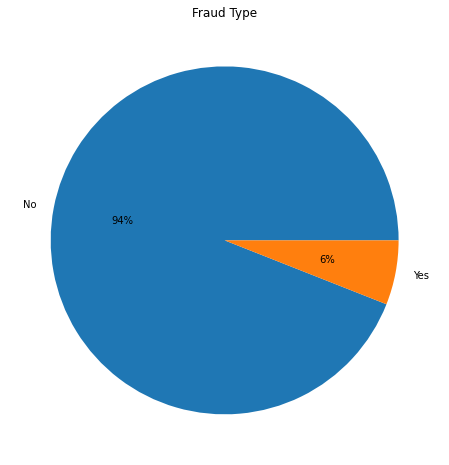

In [6]:
#create pie chart
plt.figure(figsize=(10,8))
plt.pie(df.FraudFound.value_counts().values,labels=df.FraudFound.value_counts().index,  autopct='%.0f%%')
plt.title("Fraud Type")
plt.show()

### Only 6% of Claims are detected as Fraud and since this is the target feature, shows the dataset is extremely imbalanced

In [7]:
# Replace the Labels to 0 and 1
df.loc[df['FraudFound'] == 'No','FraudFound'] = 0
df.loc[df['FraudFound'] == 'Yes','FraudFound'] = 1

df['FraudFound'] = df['FraudFound'].astype(int)

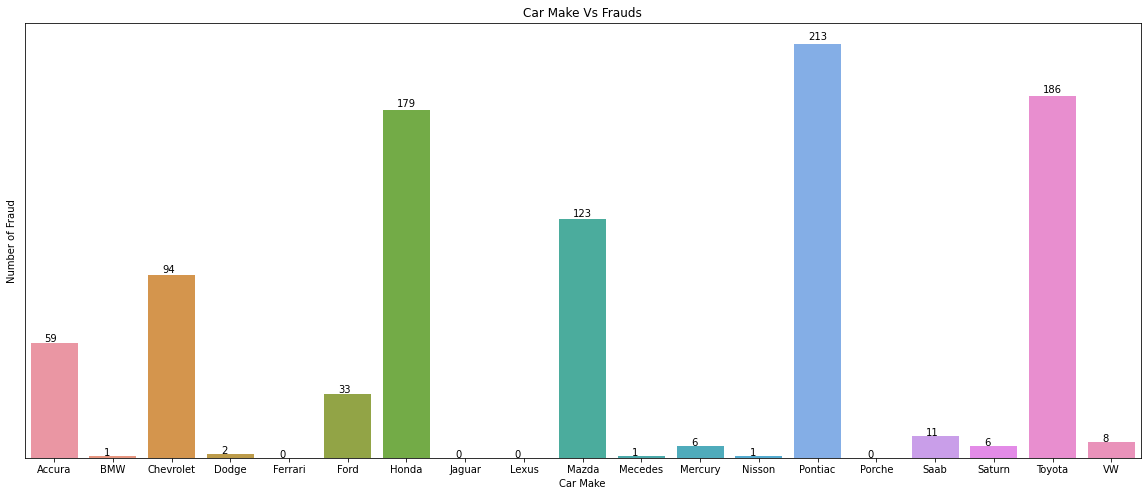

In [8]:
make = df.groupby('Make')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Car Make Vs Frauds")

ax = sns.barplot(x=make.index,y=make.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.xlabel("Car Make")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

### Most of the Fraud Cases found in Pontiac and none in Jaguar,Lexus,Porche and Ferrari

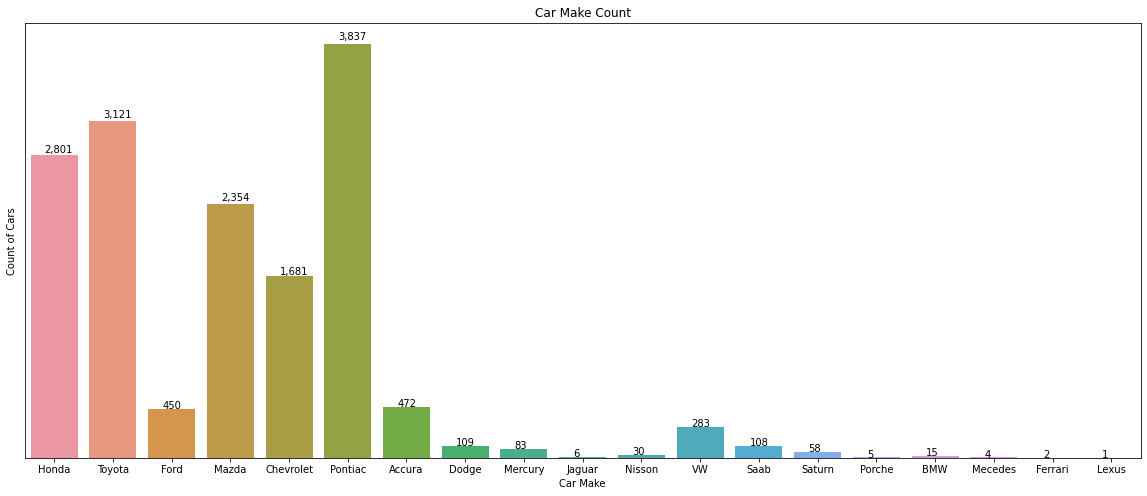

In [9]:
plt.figure(figsize=(20,8))
plt.title("Car Make Count")

ax = sns.countplot(x=df['Make'])
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.xlabel("Car Make")
plt.ylabel("Count of Cars");
plt.yticks([])
plt.show()

### The number of cars involved in an accident show why Jaguar,Lexus,Porche and Ferrari have no Fraud Claims while Pontiac have more such claims.

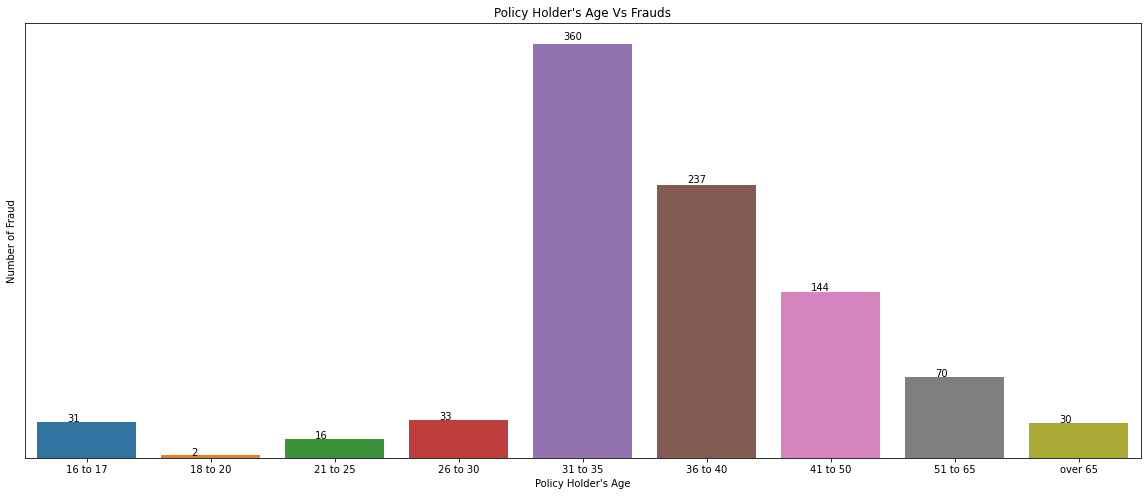

In [10]:
policyAge = df.groupby('AgeOfPolicyHolder')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Policy Holder's Age Vs Frauds")

ax = sns.barplot(x=policyAge.index,y=policyAge.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.24, p.get_height()*1.01))
plt.xlabel("Policy Holder's Age")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

### Most of the fraud seen are in the age group of 31-35 while the least is 18-20

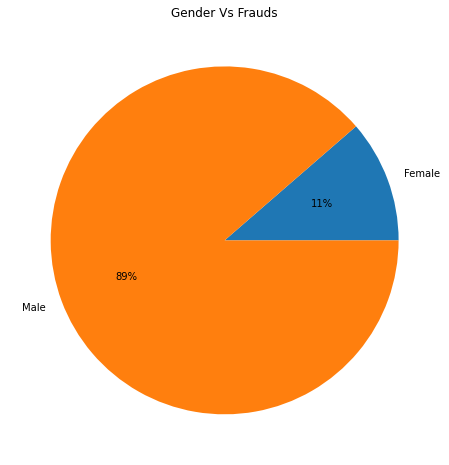

In [11]:
gender = df.groupby('Sex')['FraudFound'].sum()
plt.figure(figsize=(10,8))
plt.title("Gender Vs Frauds")

plt.pie(gender.values,labels=gender.index,  autopct='%.0f%%')

plt.show()

### Fraud by Men is more compared to Women

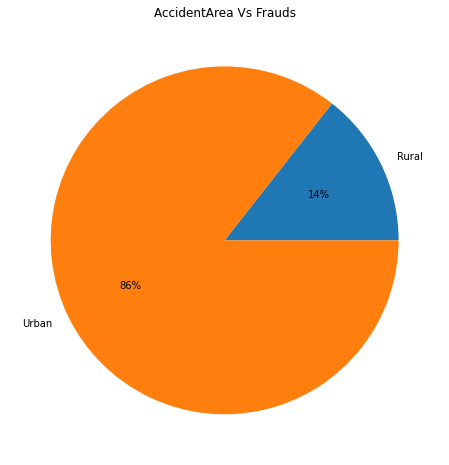

In [12]:
accidentArea = df.groupby('AccidentArea')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("AccidentArea Vs Frauds")

plt.pie(accidentArea.values,labels=accidentArea.index,  autopct='%.0f%%')

plt.show()

### More Frauds in Urban Area

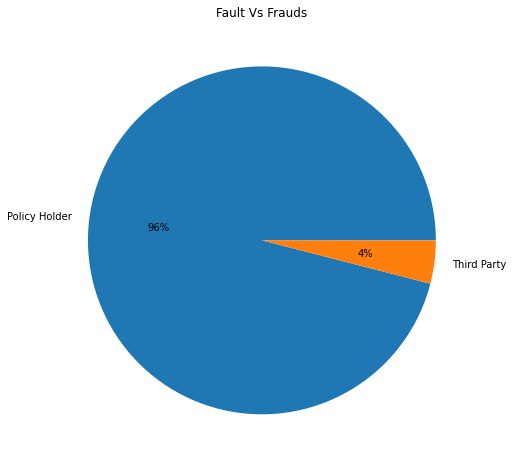

In [13]:
fault = df.groupby('Fault')['FraudFound'].sum()

plt.figure(figsize=(10,8))
plt.title("Fault Vs Frauds")
plt.pie(fault.values,labels=fault.index,  autopct='%.0f%%')
plt.show()

### Clearly, Frauds are done more by Policy Holders

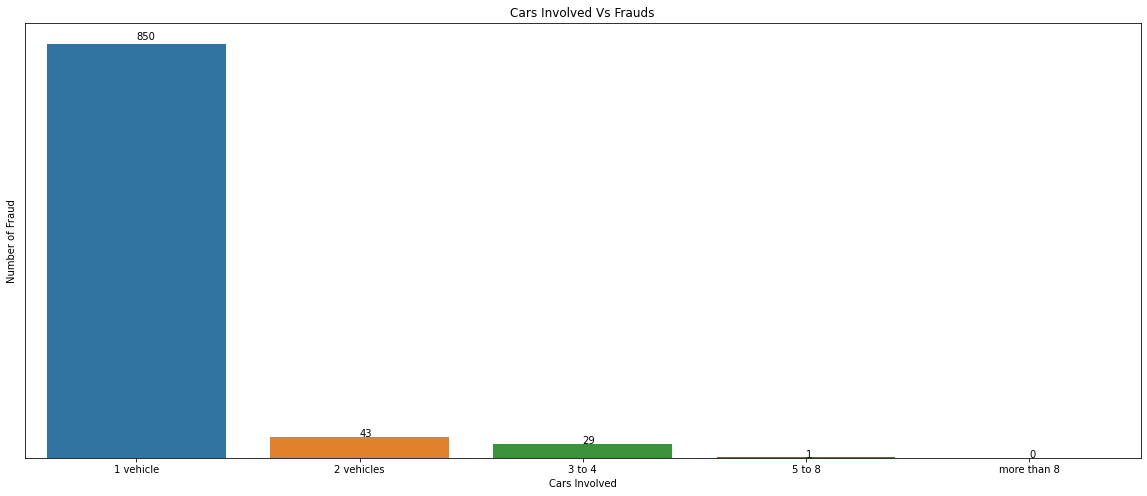

In [14]:

cars = df.groupby('NumberOfCars')['FraudFound'].sum()
plt.figure(figsize=(20,8))
plt.title("Cars Involved Vs Frauds")

ax = sns.barplot(x=cars.index,y=cars.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0.4, p.get_height()*1.01))
plt.xlabel("Cars Involved")
plt.ylabel("Number of Fraud");
plt.yticks([])
plt.show()

### Frauds are more when only a single vehicle is involved

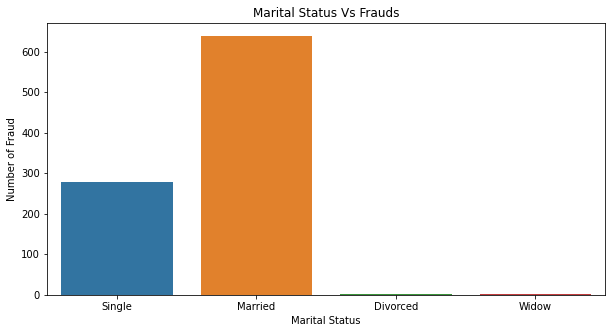

In [15]:
fraud = df[df['FraudFound'] == 1]
plt.figure(figsize=(10,5))
plt.title("Marital Status Vs Frauds")
sns.countplot(x=fraud['MaritalStatus']);
plt.xlabel("Marital Status")
plt.ylabel("Number of Fraud");

### Married are involved in more frauds

In [16]:
le = LabelEncoder()

cols = df.select_dtypes('O').columns

df[cols]= df[cols].apply(le.fit_transform)
df['Year'] = le.fit_transform(df.Year)

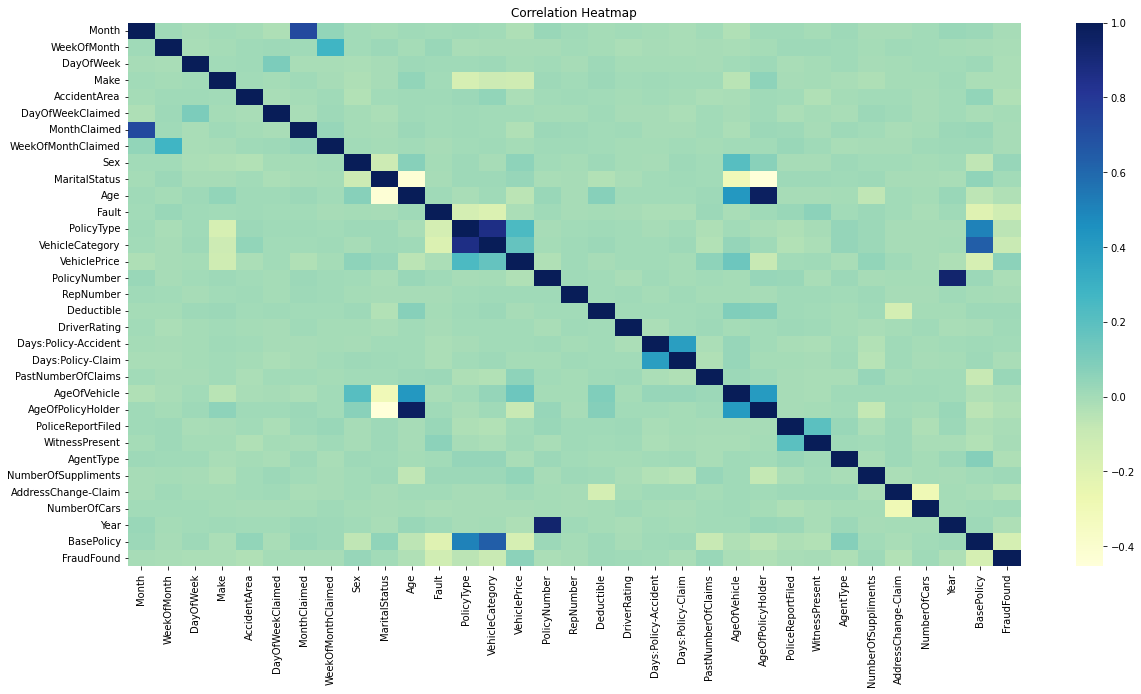

In [17]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

### Can see some strong correlation between some features and we can ignore/remove them

In [18]:
df_new = df[['Make', 'AccidentArea','Sex',\
       'MaritalStatus','Fault', 'VehicleCategory',\
       'VehiclePrice', 'Year',\
       'DriverRating', 'Days:Policy-Accident', 'Days:Policy-Claim',\
       'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',\
       'PoliceReportFiled', 'WitnessPresent', 'AgentType',\
       'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars',\
       'BasePolicy', 'FraudFound']]

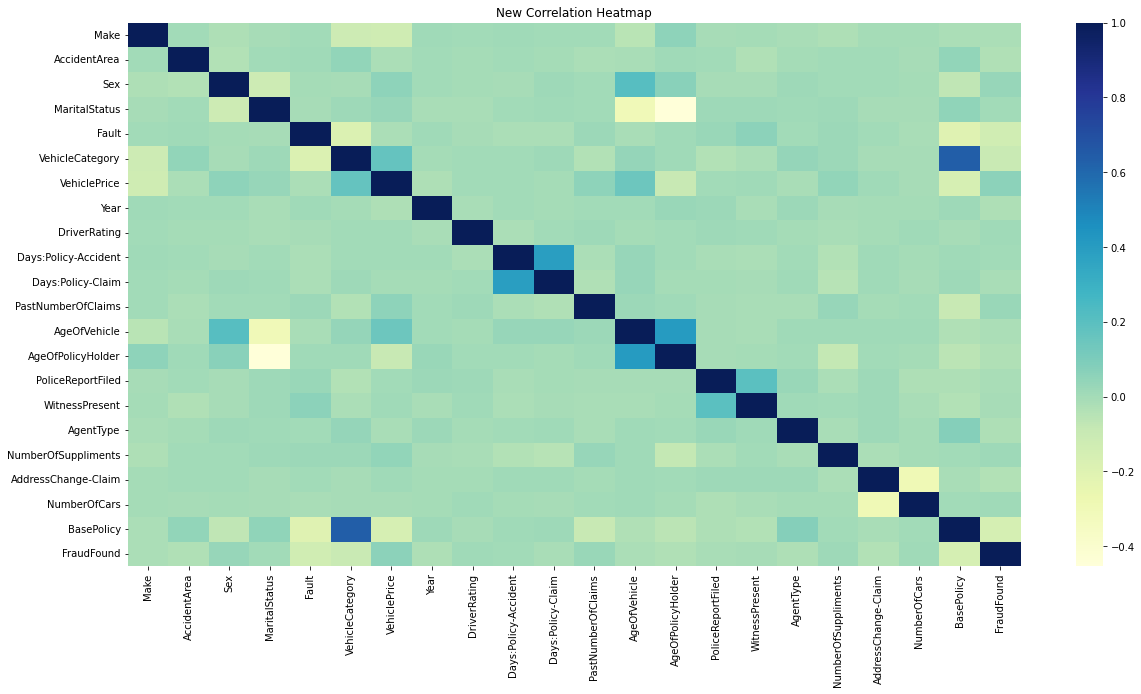

In [19]:
plt.figure(figsize=(20,10))
sns.heatmap(df_new.corr(),cmap="YlGnBu")
plt.title("New Correlation Heatmap")
plt.show()

### There still appears some correlation between BasePolicy and VehicleCategory but will leave it for now

In [20]:
def conf_matrix(y_test,y_pred):
    con_matrix = confusion_matrix(y_test,y_pred)
    con_matrix = pd.DataFrame(con_matrix,range(2),range(2))
    
    plt.figure(figsize=(5,5))
    plt.title("Confusion Matrix")
    sns.heatmap(con_matrix,annot=True,cbar=False,fmt='g')

# Data Modeling

In [21]:
X = df_new.drop('FraudFound',axis=1)
y = df_new[['FraudFound']]
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11565, 21), (3855, 21), (11565, 1), (3855, 1))

# Logistic Regression

Accuracy of thie model:		 0.9395590142671855


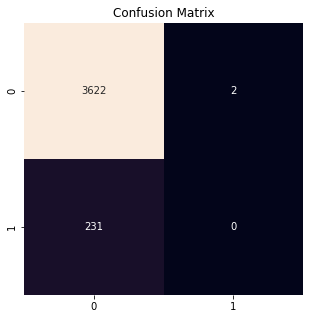

In [22]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

acc_lr=accuracy_score(y_test, lr_pred)
print("Accuracy of thie model:\t\t",acc_lr)
conf_matrix(y_test,lr_pred)

# RandomForest Classifier

Accuracy of thie model:		 0.9390402075226978


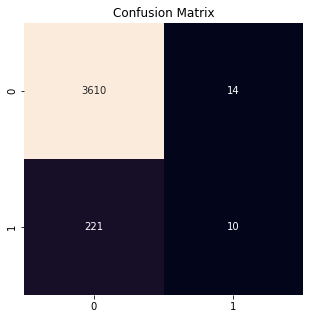

In [23]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

acc_rfc=accuracy_score(y_test, rfc_pred)
print("Accuracy of thie model:\t\t",acc_rfc)
conf_matrix(y_test,rfc_pred)

## The dataset is extremely imbalanced and will not give accurate information. This can be overcome by one of the two ways :
    Upscale the Minority Class    (FraudFound ==1) in this case
    Downsample the Majority Class (FraudFound ==0) in this case

# 1. Upscale the Minority Class

In [24]:
n = df_new.FraudFound.value_counts()[0]

df_majority = df_new[df_new.FraudFound==0]
df_minority = df_new[df_new.FraudFound==1]

df_minority_upsampled = resample(df_minority,replace=True,n_samples = n,random_state=42)

df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled.FraudFound.value_counts()

0    14497
1    14497
Name: FraudFound, dtype: int64

In [25]:
X = df_upsampled.drop('FraudFound',axis=1)
y = df_upsampled[['FraudFound']]
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21745, 21), (7249, 21), (21745, 1), (7249, 1))

## Logistic Regression

Accuracy of thie model:		 0.7356876810594565


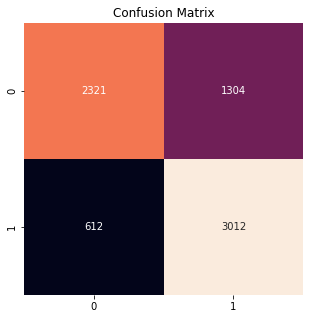

In [26]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_upscale_pred = lr.predict(X_test)

acc_lr_upscale=accuracy_score(y_test, lr_upscale_pred)
print("Accuracy of thie model:\t\t",acc_lr_upscale)
conf_matrix(y_test,lr_upscale_pred)

# RandomForest Classifier

Accuracy of thie model:		 0.9867567940405573


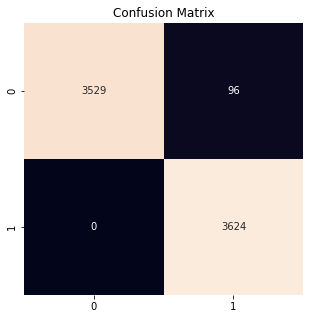

In [27]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_upscale_pred = rfc.predict(X_test)

acc_rfc_upscale=accuracy_score(y_test, rfc_upscale_pred)
print("Accuracy of thie model:\t\t",acc_rfc_upscale)
conf_matrix(y_test,rfc_upscale_pred)

# DownSample Majority Class

In [28]:
n = df_new.FraudFound.value_counts()[1]

df_majority = df_new[df_new.FraudFound==0]
df_minority = df_new[df_new.FraudFound==1]

df_majority_downsampled = resample(df_majority,replace=False,n_samples = n,random_state=42)

df_downsampled = pd.concat([df_minority,df_majority_downsampled])
df_downsampled.FraudFound.value_counts()

1    923
0    923
Name: FraudFound, dtype: int64

In [29]:
X = df_downsampled.drop('FraudFound',axis=1)
y = df_downsampled[['FraudFound']]
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1384, 21), (462, 21), (1384, 1), (462, 1))

# Logistic Regression

Accuracy of thie model:		 0.7186147186147186


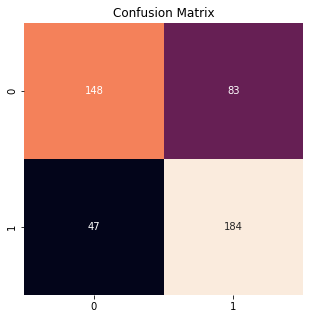

In [30]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_downscale_pred = lr.predict(X_test)

acc_lr_downscale=accuracy_score(y_test, lr_downscale_pred)
print("Accuracy of thie model:\t\t",acc_lr_downscale)
conf_matrix(y_test,lr_downscale_pred)

# RandomForest Classifier

Accuracy of thie model:		 0.7337662337662337


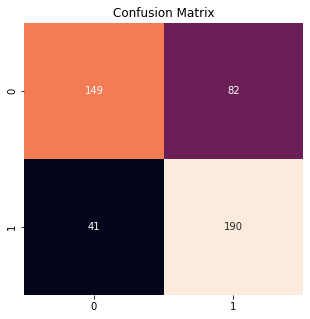

In [31]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_downscale_pred = rfc.predict(X_test)

acc_rfc_downscale=accuracy_score(y_test, rfc_downscale_pred)
print("Accuracy of thie model:\t\t",acc_rfc_downscale)
conf_matrix(y_test,rfc_downscale_pred)

# Comparison of Various Models

In [32]:
data = {'Model':['Logistic Regression','UpScale Logistic Regression','DownScale Logistic Regression',
                 'RandomForest Classifier','UpScale RandomForest Classifier','DownScale RandomForest Classifier'],
        
        'Accuracy Score':[acc_lr,acc_lr_upscale,acc_lr_downscale,acc_rfc,acc_rfc_upscale,acc_rfc_downscale]}

comparision_table=pd.DataFrame(data)                               
print(comparision_table)

                               Model  Accuracy Score
0                Logistic Regression        0.939559
1        UpScale Logistic Regression        0.735688
2      DownScale Logistic Regression        0.718615
3            RandomForest Classifier        0.939040
4    UpScale RandomForest Classifier        0.986757
5  DownScale RandomForest Classifier        0.733766
